In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download cherylalmeira/facemask

 95% 41.0M/43.4M [00:01<00:00, 38.8MB/s]
100% 43.4M/43.4M [00:01<00:00, 27.5MB/s]


In [7]:
! unzip facemask.zip

Archive:  facemask.zip
  inflating: Dataset/Test/WithMask/1.jpg  
  inflating: Dataset/Test/WithMask/10.jpg  
  inflating: Dataset/Test/WithMask/2.jpg  
  inflating: Dataset/Test/WithMask/3.jpg  
  inflating: Dataset/Test/WithMask/4.jpg  
  inflating: Dataset/Test/WithMask/5.JPG  
  inflating: Dataset/Test/WithMask/6.JPG  
  inflating: Dataset/Test/WithMask/7.jpg  
  inflating: Dataset/Test/WithMask/8.jpg  
  inflating: Dataset/Test/WithMask/9.jpg  
  inflating: Dataset/Test/WithoutMask/1.jpg  
  inflating: Dataset/Test/WithoutMask/10.JPG  
  inflating: Dataset/Test/WithoutMask/2.JPG  
  inflating: Dataset/Test/WithoutMask/3.jpg  
  inflating: Dataset/Test/WithoutMask/4.jpg  
  inflating: Dataset/Test/WithoutMask/5.jpg  
  inflating: Dataset/Test/WithoutMask/6.jpg  
  inflating: Dataset/Test/WithoutMask/7.jpg  
  inflating: Dataset/Test/WithoutMask/8.jpg  
  inflating: Dataset/Test/WithoutMask/9.jpg  
  inflating: Dataset/Train/WithMask/1.jpg  
  inflating: Dataset/Train/WithMask/10.jp

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import os
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [9]:
PATH = '/content/Dataset'

train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 162 files belonging to 2 classes.


In [10]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 20 files belonging to 2 classes.


In [11]:
print(validation_dataset)
img_path = '/content/Dataset/Validation/WithMask/5.jpg'
img_test = load_img(img_path)
print(img_test.format)

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
JPEG


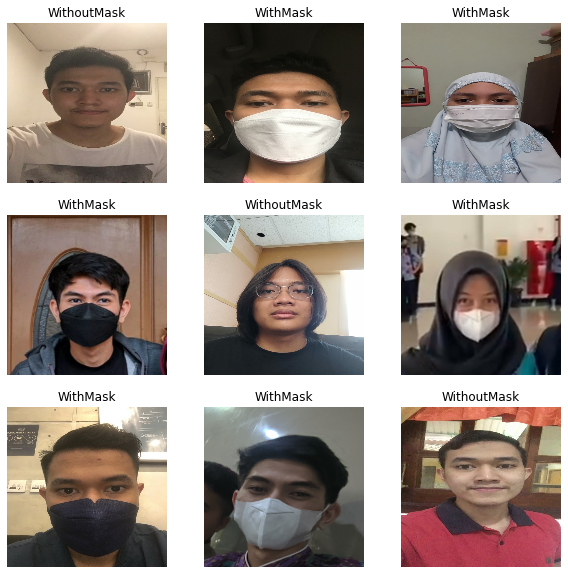

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

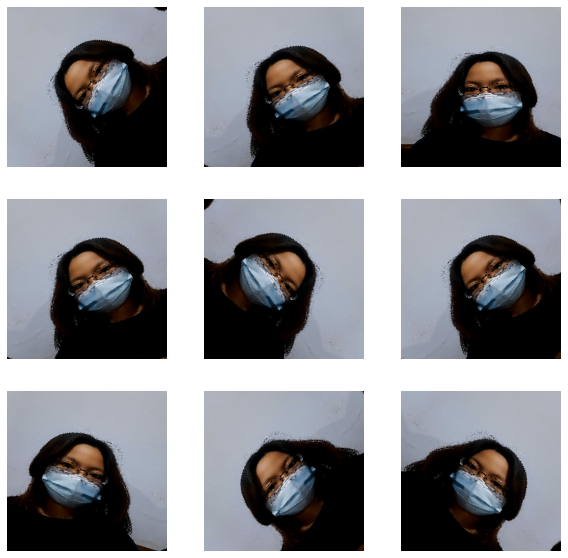

In [20]:
for image, _ in validation_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

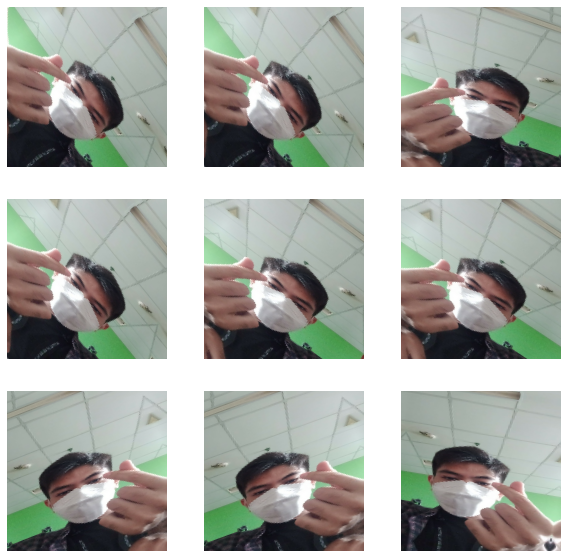

In [21]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [24]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [26]:
base_model.trainable = False

In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [31]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
len(model.trainable_variables)

2

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.6823 - accuracy: 0.6500


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.65


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
6/6 [==============================] - 5s 115ms/step - loss: 1.0105 - accuracy: 0.4444 - val_loss: 0.6609 - val_accuracy: 0.6500
Epoch 2/10
6/6 [==============================] - 2s 146ms/step - loss: 0.9336 - accuracy: 0.4568 - val_loss: 0.6457 - val_accuracy: 0.6500
Epoch 3/10
6/6 [==============================] - 2s 77ms/step - loss: 0.9520 - accuracy: 0.4136 - val_loss: 0.6324 - val_accuracy: 0.6500
Epoch 4/10
6/6 [==============================] - 2s 77ms/step - loss: 0.8443 - accuracy: 0.4877 - val_loss: 0.6217 - val_accuracy: 0.6000
Epoch 5/10
6/6 [==============================] - 2s 71ms/step - loss: 0.8269 - accuracy: 0.5370 - val_loss: 0.6133 - val_accuracy: 0.6000
Epoch 6/10
6/6 [==============================] - 2s 74ms/step - loss: 0.7617 - accuracy: 0.5556 - val_loss: 0.6079 - val_accuracy: 0.7000
Epoch 7/10
6/6 [==============================] - 2s 76ms/step - loss: 0.8635 - accuracy: 0.4691 - val_loss: 0.5988 - val_accuracy: 0.7000
Epoch 8/10
6/6 [=========

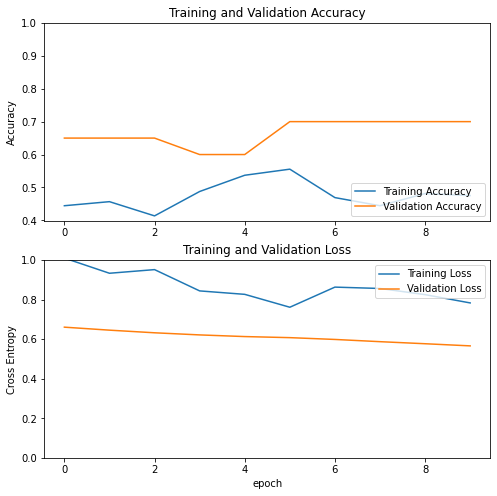

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [42]:
len(model.trainable_variables)

56

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
6/6 [==============================] - 9s 258ms/step - loss: 0.6156 - accuracy: 0.6790 - val_loss: 0.3051 - val_accuracy: 0.9000
Epoch 11/20
6/6 [==============================] - 2s 90ms/step - loss: 0.3999 - accuracy: 0.8025 - val_loss: 0.2752 - val_accuracy: 0.8000
Epoch 12/20
6/6 [==============================] - 2s 87ms/step - loss: 0.3379 - accuracy: 0.8333 - val_loss: 0.2208 - val_accuracy: 0.8500
Epoch 13/20
6/6 [==============================] - 2s 84ms/step - loss: 0.2699 - accuracy: 0.8765 - val_loss: 0.1926 - val_accuracy: 0.8500
Epoch 14/20
6/6 [==============================] - 2s 89ms/step - loss: 0.2249 - accuracy: 0.9259 - val_loss: 0.1543 - val_accuracy: 1.0000
Epoch 15/20
6/6 [==============================] - 2s 80ms/step - loss: 0.2210 - accuracy: 0.9136 - val_loss: 0.1523 - val_accuracy: 0.9000
Epoch 16/20
6/6 [==============================] - 2s 83ms/step - loss: 0.1808 - accuracy: 0.9568 - val_loss: 0.1558 - val_accuracy: 0.8500
Epoch 17/20
6/6 [==

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

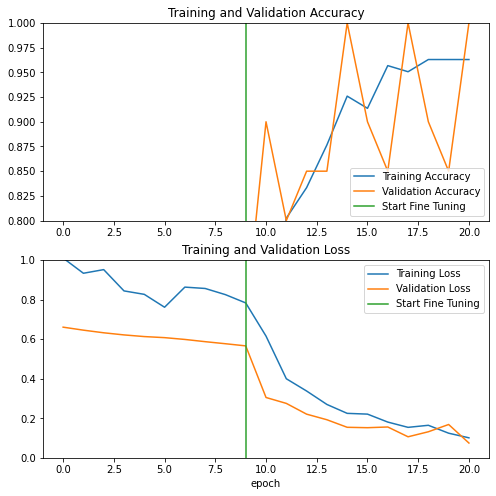

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 163ms/step - loss: 0.0747 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1]
Labels:
 [1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1]


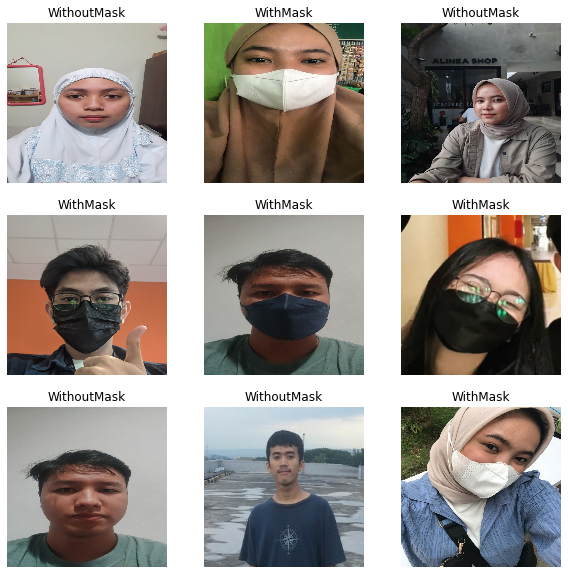

In [47]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

<Figure size 432x288 with 0 Axes>

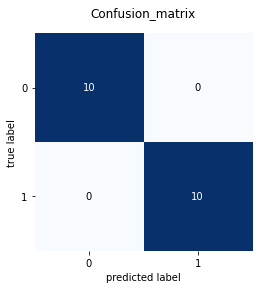

In [48]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

con=metrics.confusion_matrix(label_batch, predictions)
plt.figure()
fig, ax = plot_confusion_matrix(con, ['not masked', 'masked'])
title = plt.title('Confusion_matrix')
plt.show();

In [49]:
from sklearn.metrics import classification_report
print(classification_report(label_batch, predictions, target_names=class_names))

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00        10
 WithoutMask       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [50]:
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ROCAUC
from tensorflow.keras.models import save_model, load_model

# auc scores
auc_score1 = roc_auc_score(label_batch, predictions)

print(auc_score1)

1.0


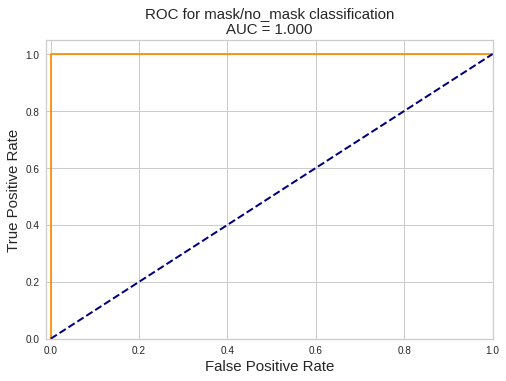

In [51]:
performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

fpr, tpr, thr = metrics.roc_curve(label_batch, predictions)
auc = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'ROC for mask/no_mask classification\nAUC = {auc:.3f}', size=15)
plt.savefig(performance_plots_dir / 'roc_classification.png', 
            bbox_inches='tight', pad_inches=0)

In [52]:
from tensorflow.keras.models import save_model, load_model

In [53]:
save_model(model, filepath='/content/drive/MyDrive/kaggle_api/mask_detector.h5')